# Sentiment Analysis

_Artificial Intelligence Nanodegree Program | Natural Language Processing_

---

With the rise of online social media platforms like Twitter, Facebook and Reddit, and the proliferation of customer reviews on sites like Amazon and Yelp, we now have access, more than ever before, to massive text-based data sets! They can be analyzed in order to determine how large portions of the population feel about certain products, events, etc. This sort of analysis is called _sentiment analysis_. In this notebook I will build an end-to-end sentiment classification system from scratch.



## Step 1: Exploring the data!

The dataset I'll going to use is very popular among researchers in Natural Language Processing, usually referred to as the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.


In [1]:
import os
import glob

def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that the data is loaded in, let's take a quick look at one of the positive reviews:

In [2]:
print(data['train']['pos'][2])

It's very funny. It has a great cast who each give great performances. Especially Sally Field and Kevin Kline. It's a well written screenplay by Andrew Bergman (Honeymoon In Vegas). I don't like soap operas, even though I never watch them. But I do love this film because it's so crazy and off the wall, that it beats the hell out of any stupid soap that they have on daytime television. In my opinion, it's the best film of 1991.


And one with a negative sentiment:

In [3]:
print(data['train']['neg'][2])

I agree totally with another of the reviewers here who was pleased "For The Birds" won the Oscar in 2002 for "Best Animated Short," not this sick material, which is pretentious at best and appealing to anyone, of course, who has no belief in heaven or hell.<br /><br />The animation was good, but so are a lot of animated shorts. And, by the way, I love dark humor but this just was unappealing from the start.<br /><br />As for the story here: a guy walking around and surrounded by nothing but grey (symbolism here) is told by a TV set (which appears every few hundred yards away) that he is in either heaven, hell, or purgatory. Each time he puts a gun to his head and shoots himself after hearing the news. I guess that would be funny in two of the three instances.


We can also make a wordcloud visualization of the reviews.

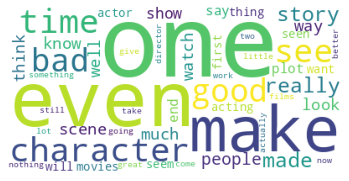

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'neg'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

### Form training and test sets

#### combine the positive and negative documents to get one unified training set and one unified test set.

In [5]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    # Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    # Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)    
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## Step 2. Preprocessing


### Convert each review to words



In [6]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abdelrhman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    #Remove HTML tags and non-letters,
    #       convert to lowercase, tokenize,
    #       remove stopwords and stem
    
    text = BeautifulSoup(review, "html5lib").get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    words = text.split()
    words = [w for w in words if w not in stopwords.words("english")]
    words = [PorterStemmer().stem(w) for w in words]    
    # Return final list of words
    return words


review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

With the function `review_to_words()` fully implemeneted, we can apply it to all reviews in both training and test datasets. This may take a while, so let's build in a mechanism to write to a cache file and retrieve from it later.

In [8]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
I saw this film with a special screening of the work of Owen Alik Shahadah. It is so interesting where did this guy come from. Now he is probably the key independent African filmmaker in the world. And I am not talking about black filmmakers I am talking about filmmakers who are rooted in culture. The idea if anything testifies to the diversity and range of African themes, with his film 500 Years Later it is a African issue. But the Idea doesn't fit that mold. Showing the artistic diversity. The film is an all African cast but the topic is a human topic which most of us could relate to. I just love the mild comedy in it. And the Kora of Tunde Jegede is just amazing, it is really a art-house gem.

--- Preprocessed words ---
['hate', 'believ', 'everyon', 'south', 'dumb', 'moral', 'bankrupt', 'stupid', 'violent', 'religi', 'nut', 'child', 'molest', 'film', 'may', 'everyon', 'poor', 'seemingli', 'ignor', 'one

## Step 3: Extracting Bag-of-Words features

Now that each document has been preprocessed, we can transform each into a Bag-of-Words feature representation. Note that we need to create this transformation based on the training data alone, as we are not allowed to peek at the testing data at all!

The dictionary or _vocabulary_ $V$ (set of words shared by documents in the training set) used here will be the one on which we train our supervised learning algorithm. Any future test data must be transformed in the same way for us to be able to apply the learned model for prediction. Hence, it is important to store the transformation / vocabulary as well.



### Compute Bag-of-Words features




In [9]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        #Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()

        #Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.fit_transform(words_test).toarray()
        
        # NOTE:  convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Read features from cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['speak', 'spend', 'entranc', 'downright', 'collaps', 'tonight', 'degener', 'nervou']

--- Preprocessed words ---
['one', 'cool', 'premis', 'right', 'bat', 'excel', 'first', 'scene', 'gotta', 'give', 'credit', 'credit', 'due', 'solid', 'charact', 'decent', 'enough', 'script', 'ghost', 'stori', 'thing', 'bother', 'whenev', 'ghost', 'appear', 'realli', 'like', 'way', 'done', 'look', 'thing', 'ghost', 'relationship', 'way', 'thing', 'went', 'first', 'scene', 'think', 'dynam', 'would', 'differ', 'thing', 'slow', 'littl', 'much', 'middl', 'felt', 'crab', 'spider', 'scene', 'good', 'end', 'actual', 'good', 'sure', 'grudg', 'basic', 'told', 'stori', 'polish', 'len', 'samurai', 'like', 'movi', 'compar', 'pleas', 'someon', 'one', 'temper', 'style', 'remak', 'movi', 'fan', 'silent', 'rage', 'would', 'absolut', 'love', 'movi']

--- Bag-of-Words features ---
[0 0 0 ... 0 0 0]

--- Label ---
neg


Let's try to visualize the Bag-of-Words feature vector for one of our training documents.

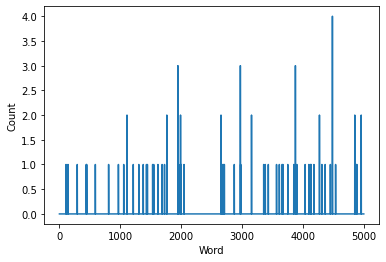

In [10]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

#### Question: Reflecting on Bag-of-Words feature representation

What is the average sparsity level of BoW vectors in our training set? In other words, on average what percentage of entries in a BoW feature vector are zero?

#### Answer:

99.98 %

### Zipf's law

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), named after the famous American linguist George Zipf, is an empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. In the figure below we plot number of appearances of each word in our training set against its rank.

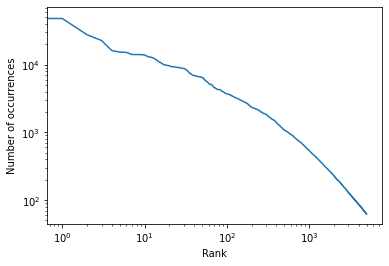

In [11]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()



### Normalize feature vectors

Bag-of-Words features are intuitive to understand as they are simply word counts. But counts can vary a lot, and potentially throw off learning algorithms later in the pipeline. So, before we proceed further, let's normalize the BoW feature vectors to have unit length.

This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [12]:
import sklearn.preprocessing as pr

#Normalize BoW features in training and test set
features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

## Step 4: Classification using BoW features

Now that the data has all been properly transformed, we can feed it into a classifier. To get a baseline model, we train a Naive Bayes classifier from scikit-learn (specifically, [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)), and evaluate its accuracy on the test set.

In [13]:
from sklearn.naive_bayes import GaussianNB

#Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.8198, test = 0.50036




### Gradient-Boosted Decision Tree classifier



In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)

    # Perform hyperparameter tuning / model selection
    param_grid = [
    {'n_estimators': [2, 4, 8, 16, 32, 64]}
  ]
    grid_search = GridSearchCV(estimator=clf,
                           param_grid=param_grid,
                           
                           )
    best_model = grid_search.fit(X_train, y_train)
    # Print final training & test accuracy
    print("[{}] Accuracy: train = {}, test = {}".format(
            best_model.__class__.__name__,
            best_model.score(X_train, y_train),
            best_model.score(X_test, y_test)))
    # Return best classifier model
    return best_model


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GridSearchCV] Accuracy: train = 0.8294, test = 0.52272


### Adverserial testing

Write a short movie review to trick the machine learning model! That is, a movie review with a clear positive or negative sentiment that your model will classify incorrectly.



In [15]:
# Write a sample review and set its true sentiment
my_review = "I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end."

true_sentiment = 'pos'  # sentiment must be 'pos' or 'neg'

# Apply the same preprocessing and vectorizing steps as the training data
my_words = review_to_words(my_review)
vectorizer = CountVectorizer(vocabulary=vocabulary,
                             preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
my_bow_features = vectorizer.transform([my_words]).toarray()  # pass an array of 1 element

# call classifier to label it
predicted_sentiment = clf2.predict(my_bow_features)[0]
print("--- My review ---")
print(my_review)
print("\n--- Preprocessed words ---")
print(my_words)
print("\nTrue sentiment: {}, predicted sentiment: {}".format(true_sentiment, predicted_sentiment))


--- My review ---
I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end.

--- Preprocessed words ---
['thought', 'would', 'like', 'bore', 'sequel', 'come', 'everyday', 'gone', 'would', 'miss', 'treat', 'bore', 'kept', 'edg', 'seat', 'till', 'end']

True sentiment: pos, predicted sentiment: neg


# 5.Sentiment Analysis with an RNN

In this notebook, I'll implement a recurrent neural network that performs sentiment analysis. Using an RNN rather than a feedfoward network is more accurate since we can include information about the *sequence* of words. Here I'll use the same IMDB dataset of movie reviews, accompanied by labels.

The architecture for this network is shown below.

<img src="assets/network_diagram.png" width=400px>

Here, we'll pass in words to an embedding layer. We need an embedding layer because we have tens of thousands of words, so we'll need a more efficient representation for our input data than one-hot encoded vectors. we can actually train up an embedding with word2vec and use it here. But it's good enough to just have an embedding layer and let the network learn the embedding table on it's own.

From the embedding layer, the new representations will be passed to LSTM cells. These will add recurrent connections to the network so we can include information about the sequence of words in the data. Finally, the LSTM cells will go to a sigmoid output layer here. We're using the sigmoid because we're trying to predict if this text has positive or negative sentiment. The output layer will just be a single unit then, with a sigmoid activation function.

We don't care about the sigmoid outputs except for the very last one, we can ignore the rest. We'll calculate the cost from the output of the last step and the training label.

In [16]:
import numpy as np
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [17]:
with open('sentiment-network/reviews.txt', 'r') as f:
    reviews = f.read()
with open('sentiment-network/labels.txt', 'r') as f:
    labels = f.read()

In [18]:
reviews[:2000]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   \nstory of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is tu

## Data preprocessing

The first step when building a neural network model is getting your data into the proper form to feed into the network. Since we're using embedding layers, we'll need to encode each word with an integer. We'll also want to clean it up a bit.


First, let's remove all punctuation. Then get all the text without the newlines and split it into individual words.

In [19]:
from string import punctuation
all_text = ''.join([c for c in reviews if c not in punctuation])
reviews = all_text.split('\n')

all_text = ' '.join(reviews)
words = all_text.split()

In [20]:
all_text[:2000]

'bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t    story of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned into an insane  violent m

In [21]:
words[:100]

['bromwell',
 'high',
 'is',
 'a',
 'cartoon',
 'comedy',
 'it',
 'ran',
 'at',
 'the',
 'same',
 'time',
 'as',
 'some',
 'other',
 'programs',
 'about',
 'school',
 'life',
 'such',
 'as',
 'teachers',
 'my',
 'years',
 'in',
 'the',
 'teaching',
 'profession',
 'lead',
 'me',
 'to',
 'believe',
 'that',
 'bromwell',
 'high',
 's',
 'satire',
 'is',
 'much',
 'closer',
 'to',
 'reality',
 'than',
 'is',
 'teachers',
 'the',
 'scramble',
 'to',
 'survive',
 'financially',
 'the',
 'insightful',
 'students',
 'who',
 'can',
 'see',
 'right',
 'through',
 'their',
 'pathetic',
 'teachers',
 'pomp',
 'the',
 'pettiness',
 'of',
 'the',
 'whole',
 'situation',
 'all',
 'remind',
 'me',
 'of',
 'the',
 'schools',
 'i',
 'knew',
 'and',
 'their',
 'students',
 'when',
 'i',
 'saw',
 'the',
 'episode',
 'in',
 'which',
 'a',
 'student',
 'repeatedly',
 'tried',
 'to',
 'burn',
 'down',
 'the',
 'school',
 'i',
 'immediately',
 'recalled',
 'at',
 'high']

### Encoding the words

The embedding lookup requires that we pass in integers to our network. The easiest way to do this is to create dictionaries that map the words in the vocabulary to integers. Then we can convert each of our reviews into integers so they can be passed into the network.



In [22]:
# Create the dictionary that maps vocab words to integers 
from collections import Counter
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

# Convert the reviews to integers, same shape as reviews list, but with integers
reviews_ints = []
for each in reviews:
    reviews_ints.append([vocab_to_int[word] for word in each.split()])

### Encoding the labels

Our labels are "positive" or "negative". To use these labels in our network, we need to convert them to 0 and 1.

> **Exercise:** Convert labels from `positive` and `negative` to 1 and 0, respectively.

In [23]:
# Convert labels to 1s and 0s for 'positive' and 'negative'
labels = labels.split('\n')
labels = np.array([1 if each == 'positive' else 0 for each in labels])

In [24]:
from collections import Counter
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 2514


Okay, a couple issues here. We seem to have one review with zero length. And, the maximum review length is way too many steps for our RNN. Let's truncate to 500 steps. For reviews shorter than 500, we'll pad with 0s. For reviews longer than 500, we can truncate them to the first 500 words.



In [25]:
# Filter out that review with 0 length
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]
len(non_zero_idx)

25000

In [26]:
reviews_ints[-1]

[]

Turns out its the final review that has zero length. But that might not always be the case, so let's make it more general.

In [27]:
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
labels = np.array([labels[ii] for ii in non_zero_idx])

In [28]:
seq_len = 500
features = np.zeros((len(reviews_ints), seq_len), dtype=int)
for i, row in enumerate(reviews_ints):
    features[i, -len(row):] = np.array(row)[:seq_len]

In [29]:
features[:10,:100]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     

## Training, Validation, Test



In [30]:
split_frac = 0.8
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(20000, 500) 
Validation set: 	(2500, 500) 
Test set: 		(2500, 500)


With train, validation, and text fractions of 0.8, 0.1, 0.1, the final shapes look like:
```
                    Feature Shapes:
Train set: 		 (20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		  (2500, 200)
```

### Design an RNN model for sentiment analysis



In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
# Set the vocabulary size
vocabulary_size =  len(vocab_to_int) + 1 # Adding 1 because we use 0's for padding, dictionary started at 1
# Set the maximum number of words per document (for both training and testing)
max_words = 500
# Design your model
embedding_size = 300
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(500))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          22221900  
_________________________________________________________________
lstm (LSTM)                  (None, 500)               1602000   
_________________________________________________________________
dense (Dense)                (None, 1)                 501       
Total params: 23,824,401
Trainable params: 23,824,401
Non-trainable params: 0
_________________________________________________________________
None


### Train and evaluate your model

In [32]:
# Compile the model, specifying a loss function, optimizer, and metrics
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
# Specify training parameters: batch size and number of epochs
batch_size = 200
num_epochs = 3


# Train your model
model.fit(train_x, train_y,
          validation_data=(val_x, val_y),
          batch_size=batch_size, epochs=num_epochs)

Epoch 1/3
50/50 [==============================] - 603s 12s/step - loss: 0.5959 - accuracy: 0.6790 - val_loss: 0.4313 - val_accuracy: 0.8032
Epoch 2/3
50/50 [==============================] - 594s 12s/step - loss: 0.3407 - accuracy: 0.8579 - val_loss: 0.5311 - val_accuracy: 0.8044
Epoch 3/3
50/50 [==============================] - 598s 12s/step - loss: 0.2194 - accuracy: 0.9190 - val_loss: 0.4592 - val_accuracy: 0.8276


In [35]:
import os
cache_dir = os.path.join("cache", "sentiment_analysis") # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

# Save the model, so that we can quickly load it in future (and perhaps resume training)
model_file = "rnn_model.h5"  # HDF5 file
model.save(os.path.join(cache_dir, model_file))

# Later we can load it using keras.models.load_model()
#from keras.models import load_model
#model = load_model(os.path.join(cache_dir, model_file))

In [36]:
# Evaluate your model on the test set
scores = model.evaluate(test_x, test_y, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.8203999996185303


## Conclusion
it's clear that rnn accuracy  is much better than other regular classification algorithms because of it's abillity to memorize sequences of data.